In [40]:
with open('libraries.py') as f:
    code = f.read()
exec(code)

In [41]:
# determine user
user = getpass.getuser()
if user == 'peymansh':
    main_folder_path = '/Users/peymansh/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output'

In [42]:
# Pick occupation
def pick_occupation(occupation):
    if occupation == 'travelAgents':
        GPT_input_occupation = 'travel agents'
        plot_title_occupation = 'Travel Agents'
        occupation_code = '41-3041'
    elif occupation == 'insuranceUnderwriters':
        GPT_input_occupation = 'insurance underwriters'
        plot_title_occupation = 'Insurance Underwriters'
        occupation_code = '13-2053'
    
    occupation_folder = f'{data_path}/daily_tasks_occupations_analysis/{occupation}'
    return GPT_input_occupation, plot_title_occupation, occupation_code, occupation_folder


In [43]:
# set alpha as AI quality metric
alpha_list = np.linspace(0.3, 1-1e-4, 1000).tolist()

In [44]:
# Pick occupation and initialize variables
occupation = 'travelAgents'
# occupation = 'insuranceUnderwriters'

GPT_input_occupation, plot_title_occupation, occupation_code, occupation_folder = pick_occupation(occupation)

### Read Data

In [45]:
suffix = ''

manual_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_{suffix}manual.csv')
#firstLastTask_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_firstLastTask.csv')
firstLastTask_conditioned_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_{suffix}firstLastTask_conditioned.csv')
#partitioned_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_partitioned.csv')
partitioned_conditioned_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_{suffix}partitioned_conditioned.csv')


### Plots

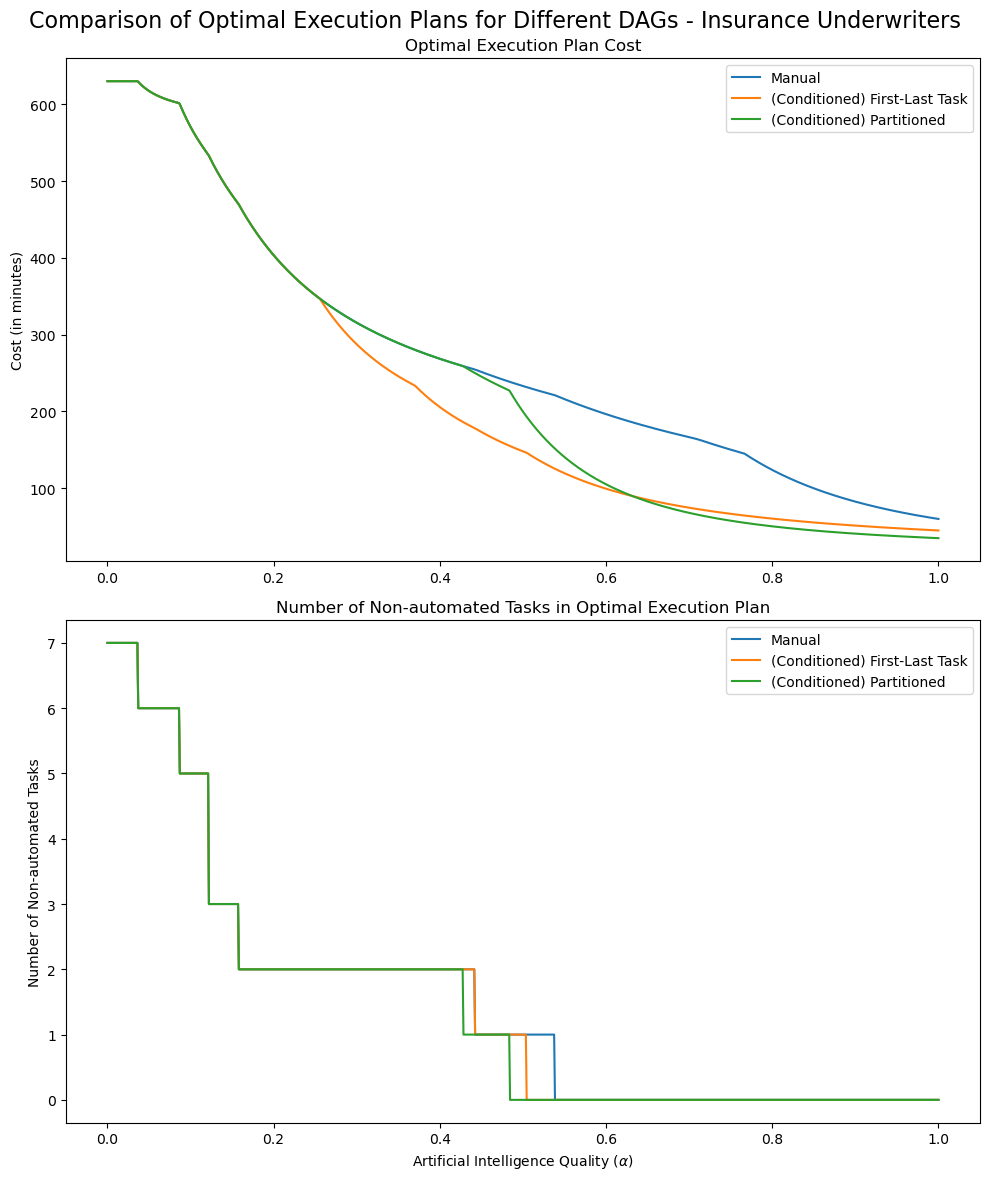

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
fig.suptitle(f'Comparison of Optimal Execution Plans for Different DAGs - {plot_title_occupation}', fontsize=16)

# Plot data on the first subplot
ax1.plot(manual_df.alpha, manual_df.cost, label = 'Manual')
ax1.plot(manual_df.alpha, firstLastTask_conditioned_df.cost, label = '(Conditioned) First-Last Task')
ax1.plot(manual_df.alpha, partitioned_conditioned_df.cost, label = '(Conditioned) Partitioned')
ax1.set_title('Optimal Execution Plan Cost')
#ax1.set_xlabel(r'Artificial Intelligence Quality ($\alpha$)')
ax1.set_ylabel('Cost (in minutes)')
ax1.legend(loc='upper right')

# Plot data on the second subplot
#ax2.axhline(y=-0, color='red', linestyle='--', alpha=0.9)
ax2.plot(manual_df.alpha, manual_df.manual_tasks_count, label = 'Manual')
ax2.plot(manual_df.alpha, firstLastTask_conditioned_df.manual_tasks_count, label = '(Conditioned) First-Last Task')
ax2.plot(manual_df.alpha, partitioned_conditioned_df.manual_tasks_count, label = '(Conditioned) Partitioned')
ax2.set_title('Number of Non-automated Tasks in Optimal Execution Plan')
ax2.set_xlabel(r'Artificial Intelligence Quality ($\alpha$)')
ax2.set_ylabel('Number of Non-automated Tasks')
ax2.legend(loc='upper right')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.savefig(f'{occupation_folder}/{occupation}_costMin_graph.png', dpi=300)

In [47]:
def get_manual_to_machine_tasks(df):
    # Convert the string representation of lists into actual Python lists
    for col in ['optimal_scheme', 'optimal_scheme_manual_tasks']:
        df[col] = df[col].apply(ast.literal_eval)

    # Define a function to subtract lists in the next row from lists in the current row
    def subtract_lists(current_list, next_list):
        # Flatten lists for easier comparison
        current_flat = [item for sublist in current_list for item in sublist]
        next_flat = [item for sublist in next_list for item in sublist]
        
        # Subtract elements
        result_flat = [item for item in current_flat if item not in next_flat]
        
        # Rebuild the list of lists structure
        result_list = [[item] for item in result_flat]
        return result_list

    # Create the new column by applying the function to each row
    new_column = [[]]
    for i in range(1, len(df)):
        current_list = df.loc[i - 1, 'optimal_scheme_manual_tasks']
        next_list = df.loc[i, 'optimal_scheme_manual_tasks']
        new_column.append(subtract_lists(current_list, next_list))

    # Add the last element as an empty list (as there is no next row to subtract from)
    #new_column.append([])

    # Assign the new column to the DataFrame
    df['newly_automated_tasks'] = new_column
    
    # Replace empty lists with an empty string
    df['newly_automated_tasks'] = df['newly_automated_tasks'].apply(lambda x: '' if x == [] else x)

    return df

manual_df = get_manual_to_machine_tasks(manual_df)
firstLastTask_conditioned_df = get_manual_to_machine_tasks(firstLastTask_conditioned_df)
partitioned_conditioned_df = get_manual_to_machine_tasks(partitioned_conditioned_df)

In [48]:
def substitute_lists(row):
    optimal_scheme_str = 'optimal_scheme'
    optimal_scheme_manual_tasks_str = 'optimal_scheme_manual_tasks'
    
    # Convert string representations of lists into actual lists
    list_a = row[optimal_scheme_str]
    list_b = row[optimal_scheme_manual_tasks_str]
    # list_a = ast.literal_eval(row[optimal_scheme_str])
    # list_b = ast.literal_eval(row[optimal_scheme_manual_tasks_str])
    
    # Iterate over elements in list_b
    for sublist_b in list_b:
        # Replace matching lists in list_a with the formatted string
        list_a = [
            f"<{sublist_b[0]}>" if sublist == sublist_b else sublist
            for sublist in list_a
        ]
    
    # Convert the list back to a string without quotes around "<x>"
    return "[" + ", ".join(
        str(item) if isinstance(item, list) else item
        for item in list_a
    ) + "]"

In [49]:
manual_df['pretty_name'] = manual_df.apply(substitute_lists, axis=1)
firstLastTask_conditioned_df['pretty_name'] = firstLastTask_conditioned_df.apply(substitute_lists, axis=1)
partitioned_conditioned_df['pretty_name'] = partitioned_conditioned_df.apply(substitute_lists, axis=1)

In [50]:
manual_df.head(20)

,alpha,optimal_schemes_count,cost,optimal_scheme,optimal_scheme_manual_tasks,manual_tasks_count,newly_automated_tasks,pretty_name
0,0.00,1,630.00,"[[0], [1], [2], [3], [4], [5], [6]]","[[0], [1], [2], [3], [4], [5], [6]]",7,,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]"
1,0.00,1,630.00,"[[0], [1], [2], [3], [4], [5], [6]]","[[0], [1], [2], [3], [4], [5], [6]]",7,,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]"
2,0.00,1,630.00,"[[0], [1], [2], [3], [4], [5], [6]]","[[0], [1], [2], [3], [4], [5], [6]]",7,,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]"
3,0.00,1,630.00,"[[0], [1], [2], [3], [4], [5], [6]]","[[0], [1], [2], [3], [4], [5], [6]]",7,,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]"
4,0.00,1,630.00,"[[0], [1], [2], [3], [4], [5], [6]]","[[0], [1], [2], [3], [4], [5], [6]]",7,,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]"
5,0.01,1,630.00,"[[0], [1], [2], [3], [4], [5], [6]]","[[0], [1], [2], [3], [4], [5], [6]]",7,,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]"
6,0.01,1,630.00,"[[0], [1], [2], [3], [4], [5], [6]]","[[0], [1], [2], [3], [4], [5], [6]]",7,,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]"
7,0.01,1,630.00,"[[0], [1], [2], [3], [4], [5], [6]]","[[0], [1], [2], [3], [4], [5], [6]]",7,,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]"
8,0.01,1,630.00,"[[0], [1], [2], [3], [4], [5], [6]]","[[0], [1], [2], [3], [4], [5], [6]]",7,,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]"
9,0.01,1,630.00,"[[0], [1], [2], [3], [4], [5], [6]]","[[0], [1], [2], [3], [4], [5], [6]]",7,,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]"


### Compare different DAGs

In [51]:
comparison_df = pd.merge(manual_df[['alpha', 'cost', 'pretty_name', 'newly_automated_tasks']], 
                         firstLastTask_conditioned_df[['alpha', 'cost', 'pretty_name', 'newly_automated_tasks']], 
                         on=['alpha'], 
                         how = 'outer')
comparison_df = pd.merge(comparison_df, 
                         partitioned_conditioned_df[['alpha', 'cost', 'pretty_name', 'newly_automated_tasks']], 
                         on=['alpha'], 
                         how = 'outer')
comparison_df = comparison_df.rename(columns={'pretty_name_x': 'optimal_scheme_manual', 
                                              'pretty_name_y': 'optimal_scheme_FLT',
                                              'pretty_name': 'optimal_scheme_P', 
                                              'cost_x': 'cost_manual', 
                                              'cost_y': 'cost_FLT',
                                              'cost': 'cost_P', 
                                              'newly_automated_tasks_x': 'newly_automated_tasks_manual', 
                                              'newly_automated_tasks_y': 'newly_automated_tasks_FLT',
                                              'newly_automated_tasks': 'newly_automated_tasks_P'})

comparison_df.to_csv(f'{occupation_folder}/{occupation}_costMin_comparison.csv', index=False)

In [52]:
comparison_df

,alpha,cost_manual,optimal_scheme_manual,newly_automated_tasks_manual,cost_FLT,optimal_scheme_FLT,newly_automated_tasks_FLT,cost_P,optimal_scheme_P,newly_automated_tasks_P
0,0.00,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",
1,0.00,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",
2,0.00,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",
3,0.00,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",
4,0.00,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",,630.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>]",
...,...,...,...,...,...,...,...,...,...,...
995,1.00,60.69,"[[0, 1, 2, 4, 5, 6], [3]]",,45.22,"[[0, 1, 3, 4, 5], [2], [6]]",,35.19,"[[0, 1, 2, 3, 4, 6], [5]]",
996,1.00,60.51,"[[0, 1, 2, 4, 5, 6], [3]]",,45.16,"[[0, 1, 3, 4, 5], [2], [6]]",,35.14,"[[0, 1, 2, 3, 4, 6], [5]]",
997,1.00,60.34,"[[0, 1, 2, 4, 5, 6], [3]]",,45.11,"[[0, 1, 3, 4, 5], [2], [6]]",,35.09,"[[0, 1, 2, 3, 4, 6], [5]]",
998,1.00,60.17,"[[0, 1, 2, 4, 5, 6], [3]]",,45.05,"[[0, 1, 3, 4, 5], [2], [6]]",,35.05,"[[0, 1, 2, 3, 4, 6], [5]]",
